 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [25/Aug/2024 11:17:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Aug/2024 11:17:14] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Aug/2024 11:17:16] "GET /upload HTTP/1.1" 200 -
127.0.0.1 - - [25/Aug/2024 11:17:16] "GET /static/styles.css HTTP/1.1" 304 -


time =  0.013788399999612011


127.0.0.1 - - [25/Aug/2024 11:17:33] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [25/Aug/2024 11:17:33] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Aug/2024 11:17:33] "GET /static/topsis_plot.png HTTP/1.1" 200 -


Koeficient bližine =  [0.65627399 0.60911531 0.55231769 0.55231938 0.63758721 0.36259485
 0.50180725]


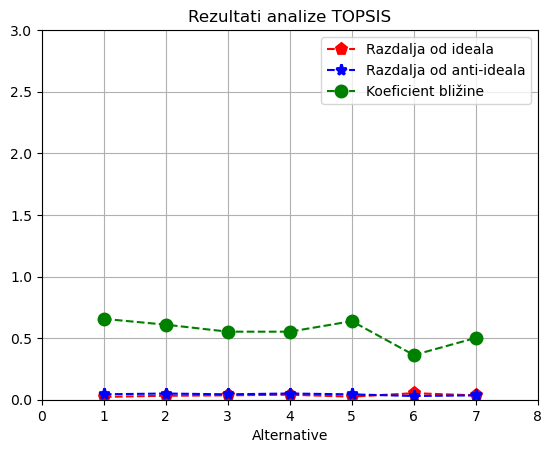

In [7]:
'''
Description: TOPSIS method
Authors: Papathanasiou, J. & Ploskas, N.
'''
    
from numpy import *
from numpy import loadtxt
from flask import Flask, render_template, request, redirect, url_for, send_file
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import io
import base64
import csv
import ast
import os
import signal
import threading



def save_to_csv(filename, data):
    """
    Shrani podatke v CSV datoteko.
    
    Parametri:
    filename (str): Ime datoteke, kamor bodo shranjeni podatki.
    data (numpy array): Matrika podatkov, ki jih želimo shraniti.
    """
    
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)
    
def read_csv_to_array(filename):
    """
    Prebere podatke iz csv datoteke.
    Parameter:
    filename (str): Ime datoteke za branje podatkov
    """
    data = []
    with open(filename, newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        for line in csv_reader:
            data.append(line)
    return data

# Korak 1: Normalizacija odločitvene matrike
def norm(x, y):
    """ normalization function; x is the array with the performances and y is the normalization method. For vector input 'v' and for linear 'l'
        Normalizacijska funkcija
    """

    if y == 'v':
        x = np.array(x, dtype=float)
        k = np.cumsum(x**2, axis=0)
        z = array([[round(x[i, j] / sqrt(k[len(x) - 1, j]), 3) for j in range(len(x[0]))]
            for i in range(len(x))])
        
        ''' Shranjevanje matrike v csv datoteko '''
        save_to_csv('temp/norm.csv', z)
        
        return z
    else:
        yy = []
        for i in range(len(x)):
            yy.append(amax(x[:, i:i + 1]))
            k = array(yy)
        z = array([[round(x[i, j] / k[j], 3)
            for j in range(len(x[0]))]
            for i in range(len(x))])
        
        ''' Shranjevanje matrike v csv datoteko '''
        save_to_csv('temp/norm.csv', z)
        
        return z

# Korak 2: Množenje matrike z utežmi
def mul_w(r, t):
    """ multiplication of each evaluation by the associate weight; r stands for the weights matrix and t for the normalized matrix resulting from norm() """
    z = array([[round(t[i, j] * r[j], 3)
        for j in range(len(t[0]))]
        for i in range(len(t))])
    
    ''' Shranjevanje matrike v csv datoteko '''
    save_to_csv('temp/norm_weighted.csv', z)
    return z

# korak 3: Izračun vrednosti za ideal in anti-ideal
def zenith_nadir(x, y):
    """ zenith and nadir virtual action function; x is the weighted normalized decision matrix and y is the action used. For min/max input 'm' and for
        absolute input enter 'a' """
    
    data = np.loadtxt("uploads/benefits.csv", delimiter=",", dtype=str)
    
    bb = []
    cc = []
    for i in range(len(x[0])):
        bb.append(amax(x[:, i:i + 1]))
        cc.append(amin(x[:, i:i + 1]))        
        b = array(bb)
        c = array(cc)
    
    combined = np.vstack((b, c))
    
    ''' preverjanje ali je atribut cost ali benefit '''
    for i in range(len(data)):
        if data[i] == 'c':
            combined[0, i] = min(b[i], c[i])
            combined[1, i] = max(b[i], c[i])
        elif data[i] == 'b':
            combined[0, i] = max(b[i], c[i])
            combined[1, i] = min(b[i], c[i])
    
    save_to_csv('temp/combined_values.csv', combined)
    
    return (combined)


# Korak 4: Izračun razdalje od vrednosti ideal in anti-ideal
def distance(x, y):
    """ calculate the distances to the ideal solution (di+) and the anti-ideal solution (di-); x is the result of mul_w() and y, z the results of
        zenith_nadir() """
    combined = x
    data = y
    
    ''' Določanje velikosti matrike '''
    rows_comb = len(combined)
    cols_comb = len(combined[0])
   
    ''' Izračun Di* in Di- '''
    a = array([[(combined[rows_comb, cols_comb] - data[0, cols_comb])**2
        for cols_comb in range(len(combined[0]))]
        for rows_comb in range(len(combined))])
    
    b = array([[(combined[rows_comb, cols_comb] - data[1, cols_comb])**2
        for cols_comb in range(len(combined[0]))]
        for rows_comb in range(len(combined))])
    
    d_plus = sqrt(sum(a, 1))
    d_minus = sqrt(sum(b, 1))
    d_combined = np.vstack((d_plus, d_minus))
    
    ''' Zapis izračuna v csv datoteko '''
    save_to_csv('temp/d_combined.csv', d_combined)

    return (d_plus, d_minus)

# TOPSIS metoda: kliče ostale funkcije in vključuje korak 5
def topsis(matrix, weight, ben, norm_m, id_sol, pl):
    """ matrix is the initial decision matrix, weight is the weights matrix, norm_m is the normalization method, id_sol is the action used, and pl
        is 'y' for plotting the results or any other string for not """
    ''' Izdelava analize TOPSIS'''
    b = ben
    z = mul_w(weight, norm(matrix, norm_m))
    s = zenith_nadir(z, b)
    p, n = distance(z, s)
    final_s = np.array([n[i] / (p[i] + n[i])
        for i in range(len(p))])
    
    ''' Izris grafa '''
    if pl == 'y':
        plt.clf()  # Dodano za čiščenje trenutne figure
        q = [i + 1 for i in range(len(matrix))]
        plt.plot(q, p, 'p--', color='red', markeredgewidth=2, markersize=8)
        plt.plot(q, n, '*--', color='blue', markeredgewidth=2, markersize=8)
        plt.plot(q, final_s, 'o--', color='green', markeredgewidth=2, markersize=8)
        plt.title('Rezultati analize TOPSIS')
        plt.legend(['Razdalja od ideala', 'Razdalja od anti-ideala', 'Koeficient bližine'])
        plt.xticks(range(len(matrix) + 2))
        plt.axis([0, len(matrix) + 1, 0, 3])
        plt.xlabel('Alternative')
        plt.grid(True)
        #plt.show()
        
        img_path = 'static/topsis_plot.png'  # Ime in pot do slike
        plt.savefig(img_path)
        
    return final_s


####################################################################################################

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'uploads/'
app.config['OTHER_FOLDER'] = 'temp/'

#flask routing
@app.route("/")
@app.route("/home")
def home():
    return render_template("home.html")


@app.route('/upload', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        files = []
        data = []
        
        ''' Uvoz podatkov '''
        for i in range(1, 4):
            file = request.files[f'file{i}']
            if file:
                filename = file.filename
                filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
                file.save(filepath)
                files.append(filename)
                with open(filepath, newline='') as csvfile:
                    reader = csv.reader(csvfile)
                    data.append(list(reader))
                    
        # Pretvorba podatkov iz string v številke
        x = [[float(value) for value in row] for row in data[0]]
        w = [float(value) for value in data[1][0]]
        b = data[2]
        
        ''' Zagon analize TOPSIS '''
        start = timeit.default_timer()
        topsis(x, w, b, 'v', 'm', 'n')
        
        ''' Priprava končnega izpisa '''
        fin = topsis(x, w, b, 'v', 'm', 'n')
        if isinstance(fin, np.ndarray):
            if fin.ndim == 1:  # Če je enodimenzionalen, ga pretvorimo v dvodimenzionalen seznam
                fin = fin.reshape(-1, 1).tolist()
        else:
            fin = fin.tolist()
        
        # Zaokroži vrednosti na 4 decimalke
        fin = [[round(value, 4) for value in row] for row in fin]
        
        # Dodajanje ključa slovarju
        dic = {f'{i+1}': val for i, val in enumerate(fin)}

        # Sprememba slovarja v seznam in urejanje vrednosti
        sorted_list = sorted([(key, val) for key, val in dic.items()], key=lambda x: x[1], reverse=True)
        
        # Branje in urejanje tabele za izpis
        with open('temp/d_combined.csv', newline='') as csvfile:
            csvreader = csv.reader(csvfile)
            datacomb = [row for row in csvreader]
        datacomb = np.array(datacomb, dtype=float)
        combined_d = [[datacomb[j][i] for j in range(len(datacomb))] for i in range(len(datacomb[0]))]
        combined_d1 = np.array(combined_d)
        np.savetxt('temp/combined_d.csv', combined_d1, delimiter=',', fmt='%s')
        
        stop = timeit.default_timer()
        print("time = ", stop - start)
        print("Koeficient bližine = ", topsis(x, w, b, 'v', 'm', 'y'))

        # Branje podatkov iz CSV datotek
        files = ['norm.csv', 'norm_weighted.csv', 'combined_d.csv', 'cc.csv', 'combined_d.csv']
        datatemp = []
        for filename in files:
            filepath = os.path.join(app.config['OTHER_FOLDER'], filename)
            with open(filepath, newline='') as csvfile:
                reader = csv.reader(csvfile)
                datatemp.append(list(reader))
        
        return render_template('display.html', data1=data[0], data2=data[1], data3=data[2], datatemp1=datatemp[0], datatemp2=datatemp[1],
                               datatemp3=datatemp[2], dic=dic, sorted_list=sorted_list)
    return render_template('upload.html')


@app.route('/manual_input', methods=['GET', 'POST'])
def manual_input():
    if request.method == 'POST':
        data1 = request.form['data1']
        data2 = request.form['data2']
        data3 = request.form['data3']
        
        # Shranjevanje podatkov v CSV datoteke
        np.savetxt(os.path.join(app.config['UPLOAD_FOLDER'], 'matrix.csv'), [row.split('\n') for row in data1.splitlines()], delimiter=',', fmt='%s')
        np.savetxt(os.path.join(app.config['UPLOAD_FOLDER'], 'weights.csv'), [row.split('\n') for row in data2.splitlines()], delimiter=',', fmt='%s')
        np.savetxt(os.path.join(app.config['UPLOAD_FOLDER'], 'benefits.csv'), [row.split('\n') for row in data3.splitlines()], delimiter=',', fmt='%s')
        
        # Branje podatkov iz CSV datotek
        files = ['matrix.csv', 'weights.csv', 'benefits.csv']
        data = []
        for filename in files:
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            with open(filepath, newline='') as csvfile:
                reader = csv.reader(csvfile)
                data.append(list(reader))
                
        # Pretvorba podatkov iz string v številke
        x = [[float(value) for value in row] for row in data[0]]
        w = [float(value) for value in data[1][0]]
        b = data[2]
                
        ''' Zagon analize TOPSIS '''            
        start = timeit.default_timer()
        topsis(x, w, b, 'v', 'm', 'n')

        ''' Priprava končnega izpisa '''
        fin = topsis(x, w, b, 'v', 'm', 'n')
        if isinstance(fin, np.ndarray):
            if fin.ndim == 1:  # Če je enodimenzionalen, ga pretvorimo v dvodimenzionalen seznam
                fin = fin.reshape(-1, 1).tolist()
        else:
            fin = fin.tolist()
        
        # Zaokroži vrednosti na 4 decimalke
        fin = [[round(value, 4) for value in row] for row in fin]
        
        # Dodajanje ključa slovarju
        dic = {f'{i+1}': val for i, val in enumerate(fin)}

        # Sprememba slovarja v seznam in urejanje vrednosti
        sorted_list = sorted([(key, val) for key, val in dic.items()], key=lambda x: x[1], reverse=True)
        
        # Branje in urejanje tabele za izpis
        with open('temp/d_combined.csv', newline='') as csvfile:
            csvreader = csv.reader(csvfile)
            datacomb = [row for row in csvreader]
        datacomb = np.array(datacomb, dtype=float)
        combined_d = [[datacomb[j][i] for j in range(len(datacomb))] for i in range(len(datacomb[0]))]
        combined_d1 = np.array(combined_d)
        np.savetxt('temp/combined_d.csv', combined_d1, delimiter=',', fmt='%s')

        stop = timeit.default_timer()
        print("time = ", stop - start)
        print("Koeficient bližine = ", topsis(x, w, b, 'v', 'm', 'y'))
        
        # Branje podatkov iz CSV datotek
        files = ['norm.csv', 'norm_weighted.csv', 'combined_d.csv', 'cc.csv']
        datatemp = []
        for filename in files:
            filepath = os.path.join(app.config['OTHER_FOLDER'], filename)
            with open(filepath, newline='') as csvfile:
                reader = csv.reader(csvfile)
                datatemp.append(list(reader))
        
        return render_template('display.html', data1=data[0], data2=data[1], data3=data[2], datatemp1=datatemp[0], datatemp2=datatemp[1],
                               datatemp3=datatemp[2], dic=dic, sorted_list=sorted_list)
    return render_template('manual_input.html')

@app.route('/shutdown', methods=['POST'])
def shutdown():
    threading.Thread(target=shutdown_server).start()
    return 'Strežnik se ustavlja...'

def shutdown_server():
    os.kill(os.getpid(), signal.SIGINT)
    
if __name__ =='__main__':
    app.run()
    


